In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import seaborn as sns

from tqdm import tqdm

import sys
sys.path.append('/Users/ag1880/Github_repos/Milstein-Lab/dentate_circuit_model/')
from optimize_dynamic_model import get_binary_input_patterns

In [2]:
#  # Train output layer
# layer_idx = self.number_of_layers
# output_activities = layer_ff_activities['layer' + str(layer_idx)]
# last_hidden_activities = layer_ff_activities['layer' + str(layer_idx - 1)]
# ff_delta_w_matrix = np.zeros_like(network['layer' + str(layer_idx)]['w_ff'])
# for unit in range(self.output_dim):
#     for j in range(self.hidden_dim[-1]):
#         if self.output_loss:
#             if j == 0:
#                 output_loss = target - output_activities
#                 output_loss_hist.append(output_loss)
#             output_difference = np.heaviside(output_loss - self.output_loss_threshold, 1)
#             if self.negative_mod_events:
#                 instr = np.heaviside(-1 * output_loss - self.output_loss_threshold, 1)
#                 output_difference[np.argwhere(instr)] = -1.
#             feedback_instructive = output_difference[unit]
#         else:
#             feedback_instructive = target[unit]
#         if j == 0:
#             output_instructive.append(np.copy(feedback_instructive))

#         if self.dynamic_Wmax[layer_idx - 1] and np.abs(feedback_instructive) == 1.:
#             output_Wmax = self.Wmax_list[layer_idx - 1][unit]
#         else:
#             output_Wmax = self.output_Wmax if self.output_Wmax is not None else self.Wmax

#         if not self.equilibrate:
#             ff_delta_w_matrix[unit, j] = self.output_learning_rate * self.btsp_rule(last_hidden_activities[j], output_activities[unit], feedback_instructive, network['layer' + str(layer_idx)]['w_ff'][unit, j], Wmax=output_Wmax, k_decay=self.decay_const, weight_decay=output_weight_decay)  # target_post[k]

# del feedback_instructive
# network['layer' + str(layer_idx)]['w_ff'] = self.update_params(network['layer' + str(layer_idx)]['w_ff'], ff_delta_w_matrix, self.rectify_output_weights)

# if self.dynamic_Wmax[layer_idx - 1]:
#     if (np.abs(output_instructive) == 1).any():
#         plateaued_units = np.array(output_instructive).astype(bool)
#         delta_wmax = self.Wmax_learning_rate * np.sign(output_loss[plateaued_units]) if self.coarse_dynamic_Wmax else self.Wmax_learning_rate * output_loss[plateaued_units]
#         self.Wmax_list[layer_idx - 1][plateaued_units] = self.update_params(self.Wmax_list[layer_idx - 1][plateaued_units], delta_wmax, self.rectify_Wmax)
#     self.Wmax_history[layer_idx - 1].append(np.copy(self.Wmax_list[layer_idx - 1]))


In [3]:
def scaled_single_sigmoid(th, peak, x=None, ylim=None):
    """
    Transform a sigmoid to intersect x and y range limits.
    :param th: float
    :param peak: float
    :param x: array
    :param ylim: pair of float
    :return: callable
    """
    if x is None:
        x = (0., 1.)
    if ylim is None:
        ylim = (0., 1.)
    if th < x[0] or th > x[-1]:
        raise ValueError('scaled_single_sigmoid: th: %.2E is out of range for xlim: [%.2E, %.2E]' % (th, x[0], x[-1]))
    if peak == th:
        raise ValueError('scaled_single_sigmoid: peak and th: %.2E cannot be equal' % th)
    slope = 2. / (peak - th)
    y = lambda x: 1. / (1. + np.exp(-slope * (x - th)))
    start_val = y(x[0])
    end_val = y(x[-1])
    amp = end_val - start_val
    target_amp = ylim[1] - ylim[0]
    return lambda xi: (target_amp / amp) * (1. / (1. + np.exp(-slope * (xi - th))) - start_val) + ylim[0]

# weight_update_sigmoid = scaled_single_sigmoid(0.01, 0.02)

# def btsp_rule(E, post, I, W, Wmax, k_decay, k_pot=1, k_dep=1, k_negative_lr=.5, weight_decay=False):
#     if weight_decay and I != -1.:
#         out = k_pot * (Wmax - W) * E * I - k_dep * W * weight_update_sigmoid(E * I) - (k_decay * E * post)
#     elif not weight_decay and I != -1.:
#         out = k_pot * (Wmax - W) * E * I - k_dep * W * weight_update_sigmoid(E * I)
#     elif I == -1:
#         out = k_negative_lr * I * E
#     return out

# delta_w_matrix = learning_rate * btsp(input_pattern, 
#                                        output, 
#                                        mod_events, 
#                                        W = dentate_net.out_in.weight, 
#                                        k_decay = 1)

In [4]:
# def btsp(E, I, W, Wmax=2, k_pot=1, k_dep=1, k_decay=0.3, weight_decay=False):
#     if weight_decay:
#         out = k_pot * (Wmax - W) * E * I - k_dep * W * tweaked_sigmoid(E * I) - (k_decay * E)# * post)
#     else:
#         out = k_pot * (Wmax - W) * E * I - k_dep * W * tweaked_sigmoid(E * I)
#     return out

def btsp(pre, Mod, W, Wmax=2, k_decay=0.001):
    '''
    :param pre: vector of pre (input) activities
    :param Mod: vector of postsynaptic modulatory events (dendritic plateaus)
    :param W: weight matrix (torch.tensor) of shape [post,pre]
    :param Wmax: int 
    :return: weight update matrix (torch.tensor) of shape [post,pre]
    '''
    Mod = Mod.repeat(W.shape[1],1).T #expand mod event vector to the dimensions of the weight matrix for fast multiplication
    potentiation = (Mod*Wmax - W)*pre
    
    weight_update_sigmoid = scaled_single_sigmoid(0.01, 0.02)
    depression = Mod*W*weight_update_sigmoid(pre*Mod)  
    
    delta_W = (Mod*Wmax - W)*pre*torch.abs(Mod) - Mod*W*weight_update_sigmoid(pre*Mod)  
    
    return delta_W


def btsp_decay(pre, Mod, W, Wmax=2, k_decay=0.001):
    '''
    :param pre: vector of pre (input) activities
    :param Mod: vector of postsynaptic modulatory events (dendritic plateaus)
    :param W: weight matrix (torch.tensor) of shape [post,pre]
    :param Wmax: int 
    :return: weight update matrix (torch.tensor) of shape [post,pre]
    '''
    Mod = Mod.repeat(W.shape[1],1).T #expand mod event vector to the dimensions of the weight matrix for fast multiplication
    potentiation = (Wmax - W)*pre*Mod
    
    weight_update_sigmoid = scaled_single_sigmoid(0.01, 0.02)
    depression = W*weight_update_sigmoid(pre*Mod)  
    
    decay = k_decay * pre
    delta_W = potentiation - depression - decay
    
    return delta_W

In [5]:
class DentateNetwork_BTSP(nn.Module):
    def __init__(self):
        self.input_size = 7
        self.output_size = 128
        
        super().__init__()
        
        self.out_in  = nn.Linear(self.input_size, self.output_size,bias=False)
        self.out_in.weight.requires_grad = False
        
    def forward(self, input_pattern):
        output = self.out_in(input_pattern)
        return output

    def train(self, epochs, learning_rate):
        all_patterns = torch.tensor(get_binary_input_patterns(7)).type(torch.float32)
        mod_event_history = []
        loss_history = []
        
        for i in tqdm(range(epochs)):
            pattern_index = np.random.randint(0,128)

            input_pattern = all_patterns[pattern_index]
            output = dentate_net.forward(input_pattern)
            target = torch.eye(128)[pattern_index]

            error = target - output
            MSE = torch.mean(error**2)
            loss_history.append(MSE)
            
            threshold = 0.5
            pos_mod_events = torch.heaviside(error-threshold,torch.tensor(0.)) # underpredicting units need to increase their activity
            neg_mod_events = torch.heaviside(-error-threshold,torch.tensor(0.)) # overpredicting units need to decrease their activity

            mod_events = pos_mod_events - neg_mod_events

            delta_W = learning_rate * btsp_decay(pre = input_pattern, 
                                           Mod = pos_mod_events, 
                                             W = dentate_net.out_in.weight)

            dentate_net.out_in.weight += delta_W
            
        return loss_history

In [6]:
# Create network
dentate_net = DentateNetwork_BTSP()

In [7]:
# Save initial state
all_patterns = torch.tensor(get_binary_input_patterns(7)).type(torch.float32)

w_init = dentate_net.out_in.weight.numpy().flatten()

output_init = []
for pattern in all_patterns:
    output_init.append(list(dentate_net.forward(pattern)))
output_init = np.array(output_init)

In [8]:
# Train network
learning_rate = 0.2
epochs = 10**4

loss_history = dentate_net.train(epochs,learning_rate)

100%|██████████| 10000/10000 [00:01<00:00, 6126.51it/s]


In [9]:
# Save final state
w_final = dentate_net.out_in.weight.numpy().flatten()

output_final = []
for pattern in all_patterns:
    output_final.append(list(dentate_net.forward(pattern)))
output_final = np.array(output_final)

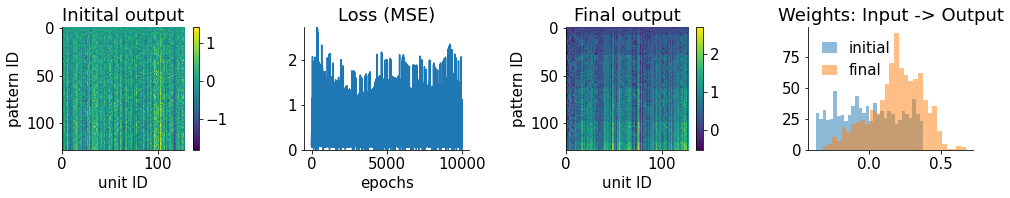

In [10]:
matplotlib.rcParams.update({'font.size': 15})

fig = plt.figure(figsize=(14,3))
axes = gs.GridSpec(nrows=1, ncols=4)
    
ax = fig.add_subplot(axes[0,0])
im = ax.imshow(output_init)
ax.set_title('Initital output')
ax.set_xlabel('unit ID')
ax.set_ylabel('pattern ID')
cbar = plt.colorbar(im, ax=ax)

ax = fig.add_subplot(axes[0,1])
ax.plot(loss_history)
ax.set_xlabel('epochs')
ax.set_title('Loss (MSE)')
ax.set_ylim([0,max(loss_history)])

ax = fig.add_subplot(axes[0,2])
im = ax.imshow(output_final)
ax.set_title('Final output')
ax.set_xlabel('unit ID')
ax.set_ylabel('pattern ID')
cbar = plt.colorbar(im, ax=ax)

ax = fig.add_subplot(axes[0,3])
ax.hist(w_init,30,alpha=0.5,label='initial')
ax.hist(w_final,30,alpha=0.5,label='final')
ax.set_title('Weights: Input -> Output')
ax.legend(loc='best', frameon=False,handlelength=1)

fig.tight_layout()
sns.despine()
plt.show()